In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi32')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 28.24it/s]

Using control points [0.0000000e+00 0.0000000e+00 1.9864545e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


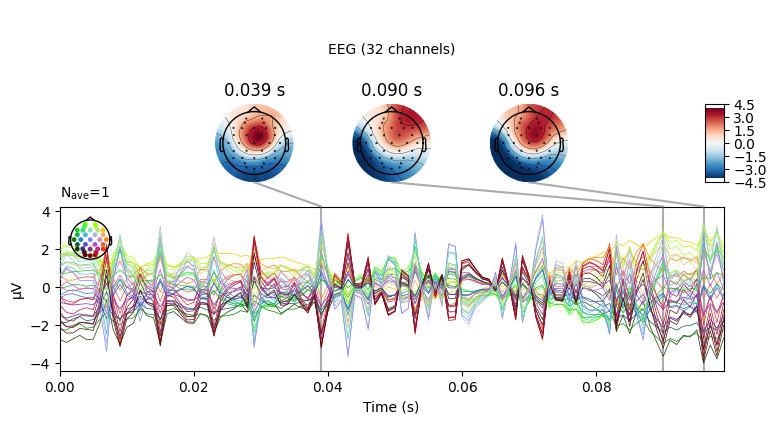

In [58]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=4, extents=(1, 2), duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Algo

In [57]:
# %matplotlib qt
# from invert.solvers import SolverLUCAS
# solver_names = ["MNE", "wMNE", "dSPM", 
#     "LORETA", "sLORETA", "eLORETA",
#     "LAURA", "S-Map", 
#     "REMBO", "SP", "COSAMP", "SOMP", "OMP",
#     "bbmf", "bbmf-lor", 
#     "Fully-Connected", "Champagne"]

# solver = SolverLUCAS()
# solver.make_inverse_operator(fwd, evoked, solvers=solver_names)
# solver.optimize_weights(fwd, info, n_samples=25)
solver.plot_weights()

Applying  Minimum Norm Estimate
Applying  Weighted Minimum Norm Estimate
Applying  Dynamic Statistical Parametric Mapping
Applying  Low Resolution Tomography
Applying  Standardized Low Resolution Tomography
Applying  Exact Low Resolution Tomography
Applying  Local Auto-Regressive Average
Applying  S-MAP
Applying  Reduce Multi-Measurement-Vector and Boost
Applying  Subspace Pursuit
Applying  Compressed Sampling Matching Pursuit
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:254: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


Applying  Simultaneous Orthogonal Matching Pursuit
Applying  Orthogonal Matching Pursuit


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\util\util.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  return 100 * np.sum( (M-M_hat)**2 ) / np.sum(M**2)


Applying  Bayesian Beamformer
Applying  Bayesian Beamformer + LORETA
Applying  Fully-Connected


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


True eeg shape:  (1, 32, 100)
est eeg shape:  (1, 32, 100)
Residual Variance(s): [33.58] [%]
Applying  Champagne
Using control points [1.21241732e-15 2.36897122e-15 5.89513263e-09]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


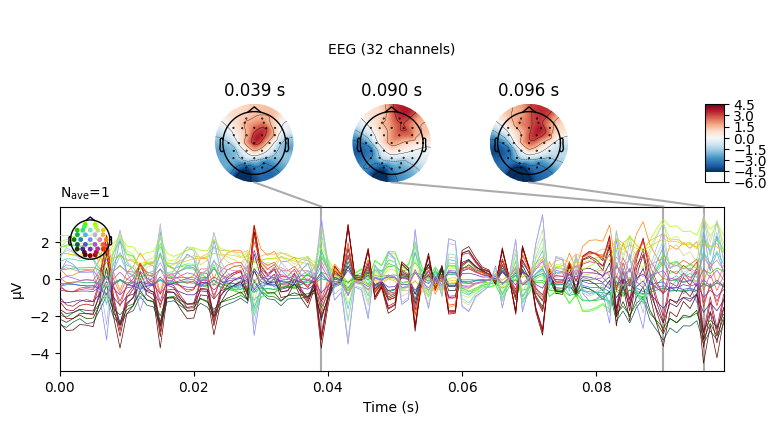

Using control points [0.00000000e+00 0.00000000e+00 1.60336988e-08]
Using control points [9.60245566e-16 2.10850188e-15 6.16740817e-09]


In [59]:
# brain = stc.plot(**pp)
# brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
#                font_size=14)
# evoked.plot_joint()

stc_hat = solver.apply_inverse_operator(evoked)
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)
evoked_ = mne.EvokedArray(leadfield@stc_hat.data, info)
evoked_.plot_joint()